In [ ]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RYGate
import numpy as np

cube1 = QuantumRegister(1, name="cube1")  # 4 qubits for 4 colors
cube2 = QuantumRegister(1, name="cube2")
cube3 = QuantumRegister(1, name="cube3")
cube4 = QuantumRegister(1, name="cube4")
qc = QuantumCircuit(cube1, cube2, cube3, cube4, name="InstantInsanityAnsatz")


cube = ['+X', '-X', '+Y', '-Y', '+Z', '-Z']

cube_top = ['X', 'Y', 'Z']
cube_bottom = []
cube_front = []
cube_back = []

cube1 = ['+X', '-X', '-X', '-X', '+Z', '-Z']
cube2 = ['+X', '+X', '-X', '+Z', '-Z', '-Z']
cube3 = ['+X', '-X', '+Z', '+Z', '-Z', '-Z']
cube4 = ['+X', '+X', '-X', '-X', '+Z', '-Z']



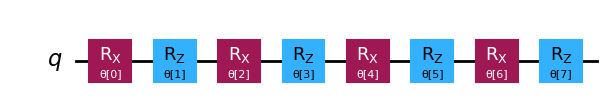

In [49]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

# 4 qubits, rx
ansatz = TwoLocal(
    num_qubits=1,
    rotation_blocks=['rx', 'rz'],
    entanglement_blocks=None,  # 얽힘 없음
    entanglement=None,
    reps=3
)

ansatz.decompose().draw('mpl')


In [50]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# H = I - |0000><0000| = I - (1 + Z0)(1 + Z1)(1 + Z2)(1 + Z3)/16
# 전개 시 총 16개의 항이 생깁니다.
'''
terms = []
coeffs = []

for i in range(2):  # 2^4
    bin_str = f"{i:02b}"
    pauli_str = ''
    coeff = 1.0
    for b in bin_str:
        if b == '0':
            pauli_str += 'X'
            coeff *= 1
        else:
            pauli_str += 'Z'
            coeff *= -1
    terms.append(pauli_str[::-1])  # Qiskit은 오른쪽이 qubit 0
    coeffs.append(coeff / 2)

terms.append('I')
coeffs.append(-1)  # I - projector

observable = SparsePauliOp.from_list(list(zip(terms, coeffs)))
'''

observable = SparsePauliOp.from_list([
    ('I', 0.5),
    ('Z', -0.5)
])
print(observable)

SparsePauliOp(['I', 'Z'],
              coeffs=[ 0.5+0.j, -0.5+0.j])


In [51]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler, realbackend,backend):

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        if realbackend == 1:
            pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
            fidelity_circuit = pm.run(fidelity_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [52]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian, realbackend, backend):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler, realbackend, backend)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [53]:
from qiskit.primitives import StatevectorSampler
from qiskit.primitives import StatevectorEstimator

sampler = StatevectorSampler(default_shots=4092)
estimator = StatevectorEstimator()

In [60]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 4
betas = [100, 100, 100]
x0 = np.zeros(8)

In [61]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable, realbackend, None), method="COBYLA", options={'maxiter': 200, 'tol':0.000001})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 9.477418849712649e-13
       x: [-4.751e-07  1.250e-01 -3.459e-07  5.002e-07 -6.579e-07
            9.114e-12 -4.710e-07 -1.575e-11]
    nfev: 107
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.121250522307169
       x: [ 1.090e+00 -3.398e-03  1.075e+00  2.755e-02  1.019e+00
            1.001e+00  1.632e-02  2.507e-02]
    nfev: 104
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 97.95021665105803
       x: [ 1.001e+00  1.001e+00  8.795e-01  5.891e-04 -3.070e-02
            4.191e-04 -7.885e-04 -4.372e-04]
    nfev: 95
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 103.23937901601916
       x: [-1.156e+00  8.239e-01 -5.201e-01  1.768e-01 -5.350e-01
           -1.894e-01  3.764e-01  6.673e-02]
    nfev: 125
   maxcv: 0.0


In [12]:
from qiskit.quantum_info import Operator, SparsePauliOp
import numpy as np

# 예시: 2-큐비트 Hermitian 행렬
H = np.array([
    [0, 1, 3, 2],
    [1, 1, 2, 3],
    [3, 2, 0, 0],
    [2, 3, 0, 3]
], dtype=complex)


op = Operator(H)

# 3. SparsePauliOp로 Pauli basis 분해
pauli_decomp = SparsePauliOp.from_operator(op)

# 4. 출력
for pauli, coeff in zip(pauli_decomp.paulis, pauli_decomp.coeffs):
    if not np.isclose(coeff, 0):
        print(f"{coeff:.3f} * {pauli}")

1.000+0.000j * II
0.500+0.000j * IX
-1.000+0.000j * IZ
3.000+0.000j * XI
2.000+0.000j * XX
-0.500+0.000j * ZI
0.500+0.000j * ZX
0.500+0.000j * ZZ


In [13]:
# 고윳값, 고유벡터 계산
eigvals, eigvecs = np.linalg.eigh(op.data)  # .data는 ndarray

# 출력
print("고윳값:")
print(eigvals)

print("\n고유벡터 (열 벡터):")
print(eigvecs)

고윳값:
[-3.81304545 -0.73722724  1.78881388  6.76145881]

고유벡터 (열 벡터):
[[ 0.59019253+0.j -0.53694538+0.j -0.42922303+0.j  0.42323755+0.j]
 [ 0.35131237+0.j  0.77010195+0.j  0.04301563+0.j  0.53072805+0.j]
 [-0.64861601+0.j  0.09580797+0.j -0.67175118+0.j  0.34477305+0.j]
 [-0.32794764+0.j -0.33083755+0.j  0.6022189 +0.j  0.64832805+0.j]]


Problem name: my problem

Minimize
  0

Subject to
  No constraints

  No variables

